<h1>FIFA 23 ML Project  <img src="https://img.icons8.com/color/48/null/football-team.png"/></h1>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("./players_fifa23_cleaned.csv")
data.head()

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,91,88,91,67,66,67,62,53,62,22
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,89,84,89,67,67,67,63,58,63,21
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,86,83,86,67,69,67,64,63,64,22
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91,91,91,82,82,82,78,72,78,24
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,92,84,92,70,66,70,66,57,66,21


In [4]:
data.shape

(18539, 90)

In [5]:
needed_columns = ['ID', 'Name', 'Age', 'Height', 'Weight',
       'Overall', 'Potential', 'Growth', 'TotalStats',
       'BaseStats', 'BestPosition', 'Club', 'ValueEUR', 'WageEUR',
       'ReleaseClause', 'ContractUntil', 'ClubJoined', 'OnLoad',
       'PreferredFoot', 'IntReputation', 'WeakFoot','Nationality',
       'SkillMoves', 'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal',
       'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal',
       'PhysicalityTotal', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


data = data[needed_columns]

<img src="https://gamesmix.net/wp-content/uploads/2022/03/FIFA-23.jpeg" width="900"/>

<h2>Split the Data to Train and Test sets:</h2>

In [28]:
X = data.drop(["BestPosition", "Nationality", "ID"], axis = 1)
Y = pd.DataFrame(data["BestPosition"])

top = data.sort_values(by=["Overall"], ascending=False).head(20)

In [29]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [30]:
X_Train = X_Train.drop(["Name"], axis = 1)
test_names = X_Test["Name"]
X_Test = X_Test.drop(["Name"], axis = 1)

top_pos = top["BestPosition"]
top_names = top["Name"]
top = top.drop(["Name", "BestPosition", "Nationality", "ID"], axis = 1)

<h3>3. Handle the Imbalanced Data:</h3>

<AxesSubplot:xlabel='BestPosition', ylabel='count'>

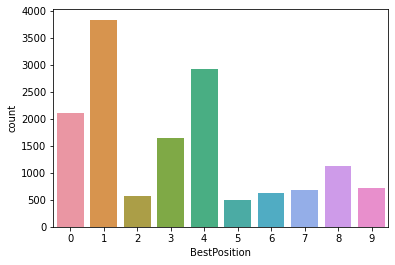

In [31]:
sns.countplot(x="BestPosition", data = Y_Train)

In [32]:
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling  import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)

In [33]:
print(f' X_shape: {X_Train.shape} \n y_shape: {Y_Train.shape}')

 X_shape: (27732, 61) 
 y_shape: (27732, 1)


<AxesSubplot:xlabel='BestPosition', ylabel='count'>

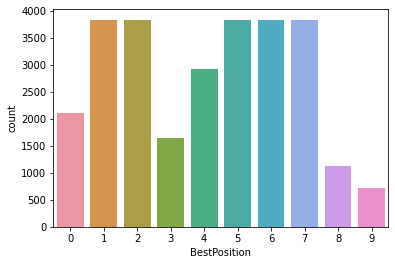

In [34]:
sns.countplot(x="BestPosition", data = Y_Train)

<h3>4. Feature Scaling:</h3>

In [35]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_Train = mms.fit_transform(X_Train)
X_Test = mms.fit_transform(X_Test)

top = mms.fit_transform(top)

# Modeling

## A. Predict the Position of the Player Using 8 Classification Algorithms:

<h3>Functions to be Used: </h3>

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

# Function to check the classification report
def classification_report_fun(model_name, actual, predicted):
    print(f'The Classification Report for {model_name} Classifier:')
    print(classification_report(actual, predicted))
    
models_names = []
models_scores = []
models_auc_scores = []

In [37]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [38]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [39]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [40]:
def draw_pco(Y_Proba, classes):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    plt.figure(figsize = (12, 8))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]

        # Prepares an auxiliar dataframe to help with the plots
        #df_aux = X_Test.copy()
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if list(mapping.keys())[list(mapping.values()).index(y)] == c else 0 for y in Y_Test.values]
        df_aux['prob'] = Y_Proba[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(c)
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvR")

        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

    plt.tight_layout()

In [41]:
positions = ['CF', 'CM', 'RW', 'GK', 'CB', 'LW', 'LM', 'LB','RM', 'RB']
positions

['CF', 'CM', 'RW', 'GK', 'CB', 'LW', 'LM', 'LB', 'RM', 'RB']

<h3>1. Logistic Regression:</h3>

In [42]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [43]:
lr.fit(X_Train , Y_Train)

LogisticRegression()

In [44]:
lr.score(X_Train, Y_Train)

0.7000576950814943

In [45]:
lr.score(X_Test, Y_Test)

0.7536585365853659

In [46]:
Y_Pred_lr = lr.predict(X_Test)

In [47]:
models_names.append("Logistic Regression")
models_scores.append(lr.score(X_Test, Y_Test))

In [48]:
classification_report_fun("Logistic Regression", Y_Test, Y_Pred_lr)

The Classification Report for Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       522
           1       0.91      0.74      0.82       962
           2       0.23      0.71      0.34       132
           3       1.00      1.00      1.00       391
           4       0.89      0.95      0.92       711
           5       0.32      0.16      0.22       116
           6       0.35      0.65      0.46       168
           7       0.61      0.83      0.70       178
           8       0.68      0.36      0.47       313
           9       0.78      0.32      0.45       197

    accuracy                           0.75      3690
   macro avg       0.67      0.66      0.63      3690
weighted avg       0.81      0.75      0.76      3690



In [49]:
Y_Proba_lr = lr.predict_proba(X_Test)

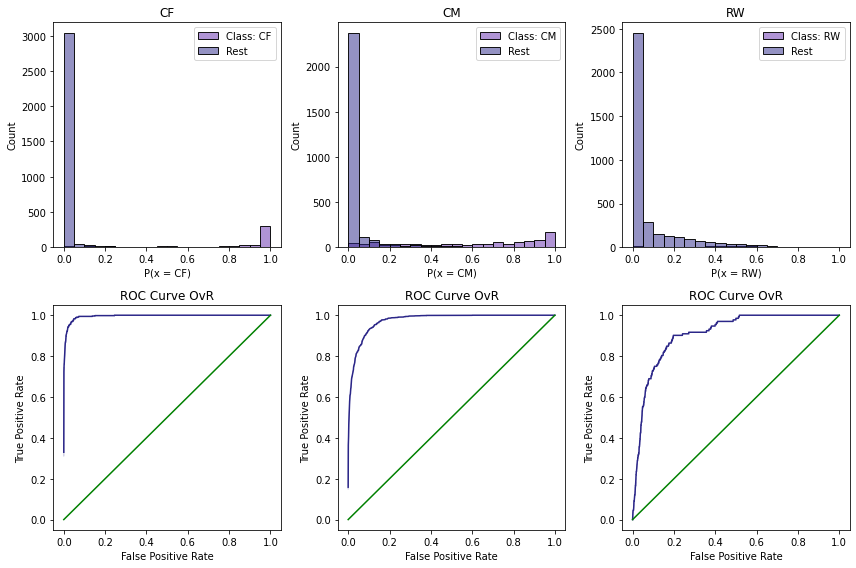

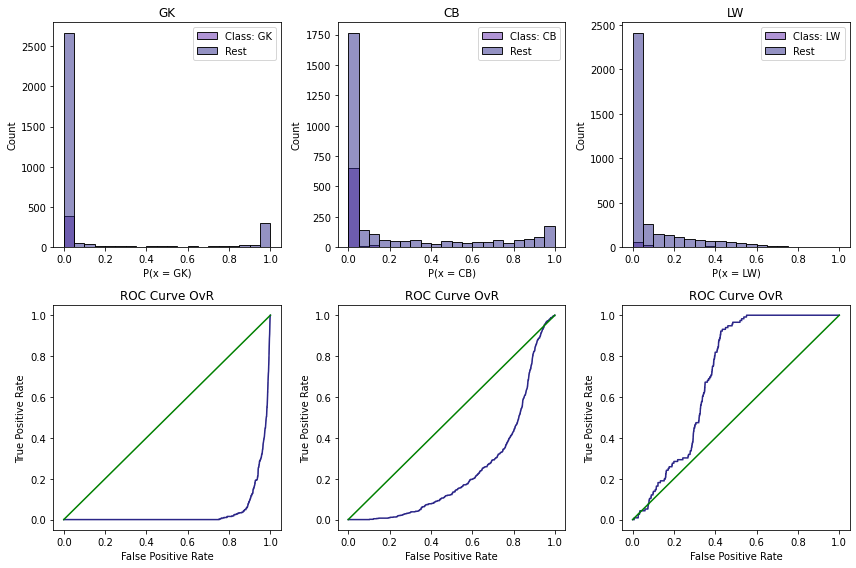

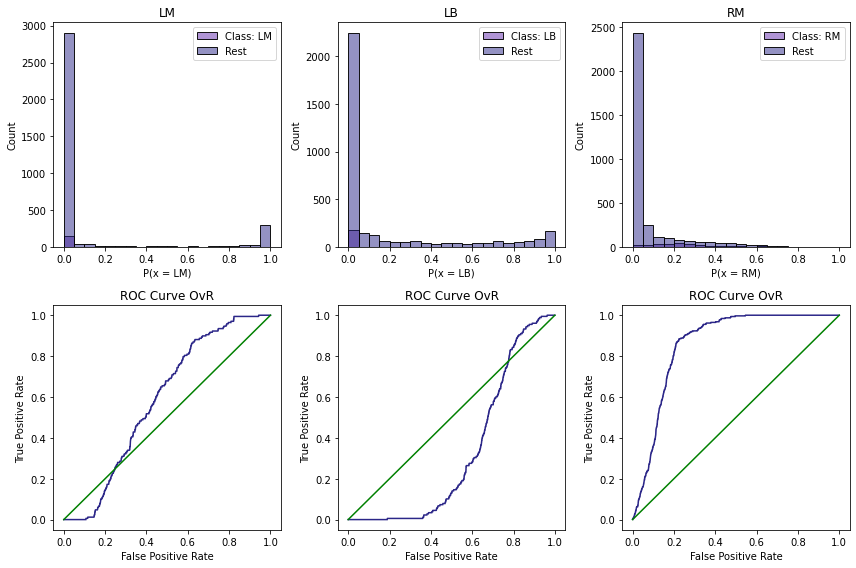

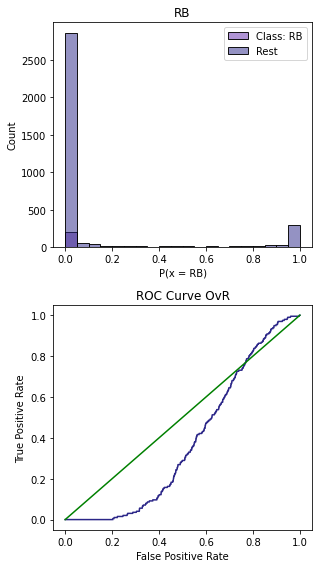

In [50]:
draw_pco(Y_Proba_lr, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_lr, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_lr, ['LM', 'LB','RM'])
draw_pco(Y_Proba_lr, ['RB'])

In [51]:
auc_score_lr = roc_auc_score(Y_Test, Y_Proba_lr, multi_class = 'ovr', average = 'macro')
auc_score_lr

0.9644733408501228

In [52]:
models_auc_scores.append(auc_score_lr)

<h3>2. Random Forest:</h3>

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini',n_estimators=50)

In [54]:
rf.fit(X_Train, Y_Train)

RandomForestClassifier(n_estimators=50)

In [55]:
rf.score(X_Train, Y_Train)

1.0

In [56]:
rf.score(X_Test, Y_Test)

0.8059620596205962

In [57]:
Y_Pred_rf = rf.predict(X_Test)

In [58]:
models_names.append("Random Forest")
models_scores.append(rf.score(X_Test, Y_Test))

In [59]:
classification_report_fun("Random Forest", Y_Test, Y_Pred_rf)

The Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       522
           1       0.81      0.85      0.83       962
           2       0.40      0.36      0.38       132
           3       1.00      1.00      1.00       391
           4       0.89      0.94      0.92       711
           5       0.46      0.24      0.32       116
           6       0.57      0.48      0.52       168
           7       0.68      0.80      0.74       178
           8       0.66      0.58      0.62       313
           9       0.71      0.64      0.67       197

    accuracy                           0.81      3690
   macro avg       0.71      0.68      0.69      3690
weighted avg       0.80      0.81      0.80      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [60]:
Y_Proba_rf = rf.predict_proba(X_Test)

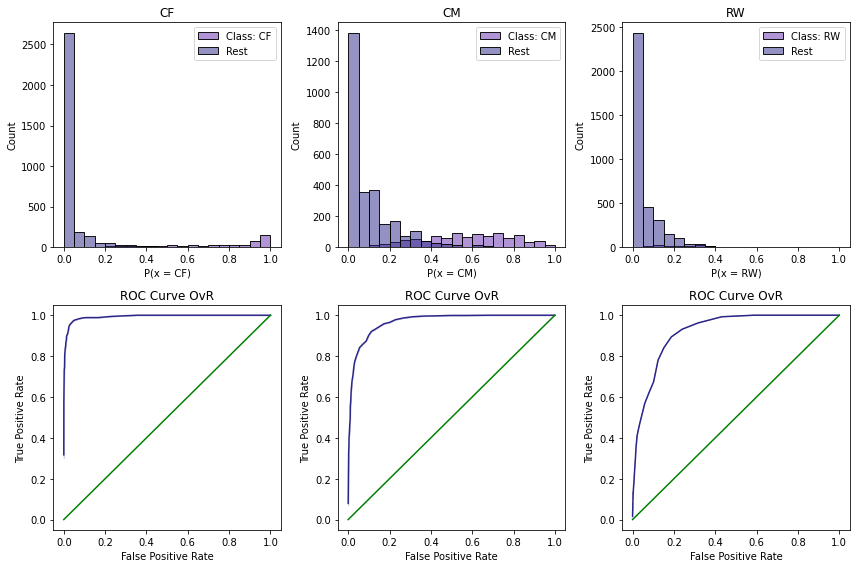

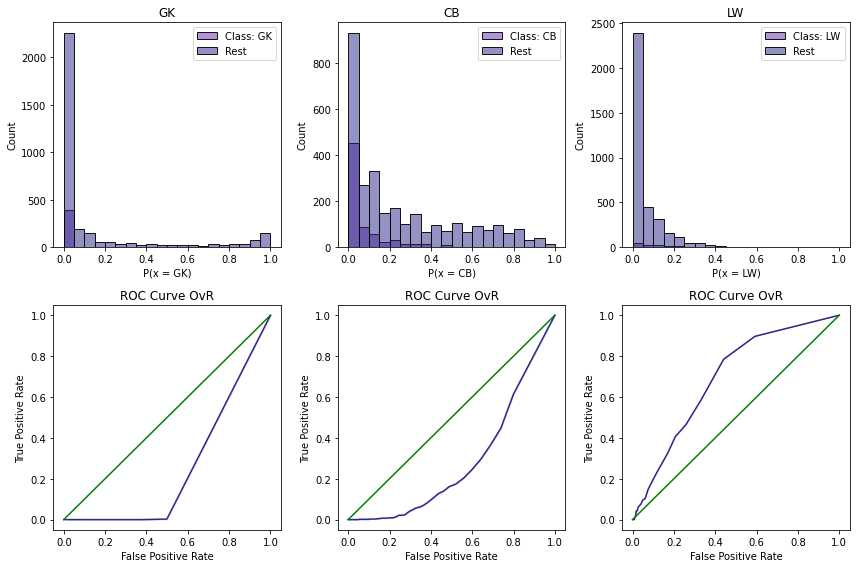

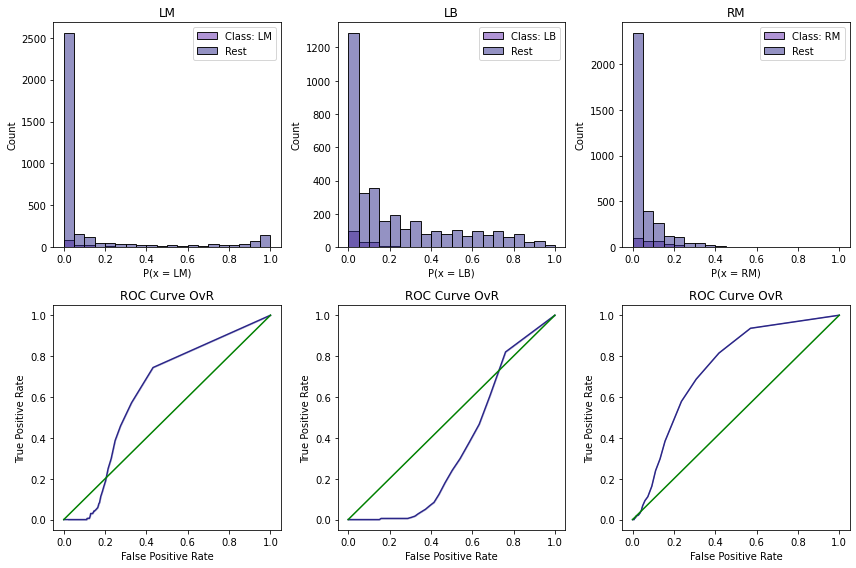

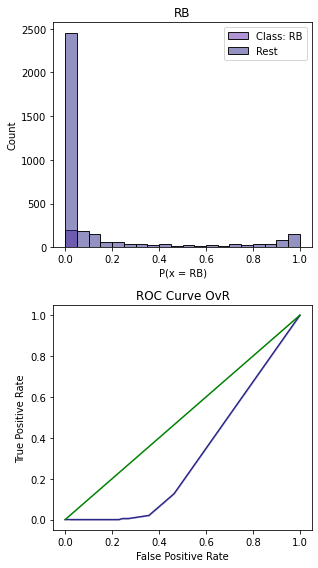

In [61]:
draw_pco(Y_Proba_rf, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_rf, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_rf, ['LM', 'LB','RM'])
draw_pco(Y_Proba_rf, ['RB'])

In [62]:
auc_score_rf = roc_auc_score(Y_Test, Y_Proba_rf, multi_class = 'ovr', average = 'macro')
auc_score_rf

0.9643996460199717

In [63]:
models_auc_scores.append(auc_score_rf)

<h3>3. XGB:</h3>

In [64]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

In [65]:
xgb.fit(X_Train, Y_Train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [66]:
xgb.score(X_Train, Y_Train)

1.0

In [67]:
xgb.score(X_Test, Y_Test)

0.8249322493224932

In [68]:
Y_Pred_xgb = xgb.predict(X_Test)

In [69]:
models_names.append("XGB")
models_scores.append(xgb.score(X_Test, Y_Test))

In [70]:
classification_report_fun("XGB", Y_Test, Y_Pred_xgb)

The Classification Report for XGB Classifier:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       522
           1       0.90      0.85      0.88       962
           2       0.36      0.33      0.34       132
           3       1.00      1.00      1.00       391
           4       0.92      0.96      0.94       711
           5       0.41      0.34      0.37       116
           6       0.53      0.54      0.54       168
           7       0.72      0.75      0.73       178
           8       0.65      0.68      0.66       313
           9       0.68      0.76      0.72       197

    accuracy                           0.82      3690
   macro avg       0.71      0.71      0.71      3690
weighted avg       0.82      0.82      0.82      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [71]:
Y_Proba_xgb = xgb.predict_proba(X_Test)

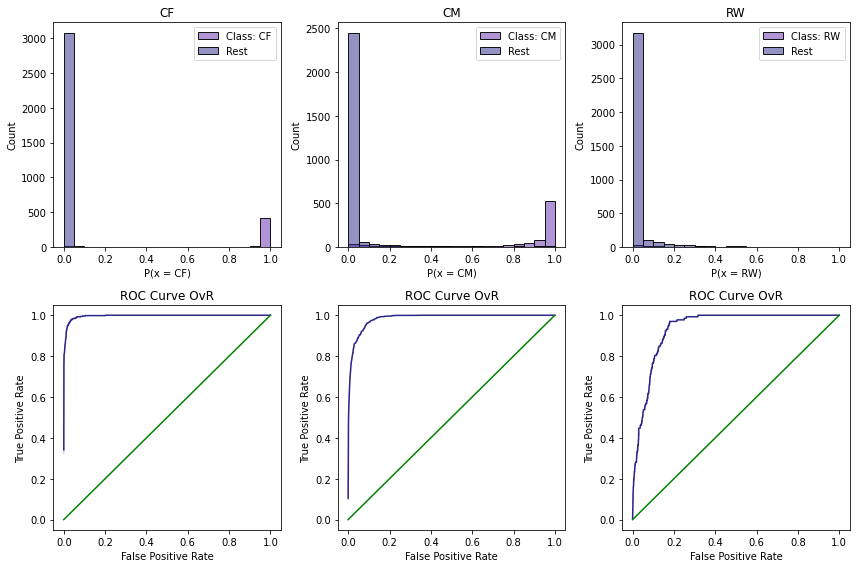

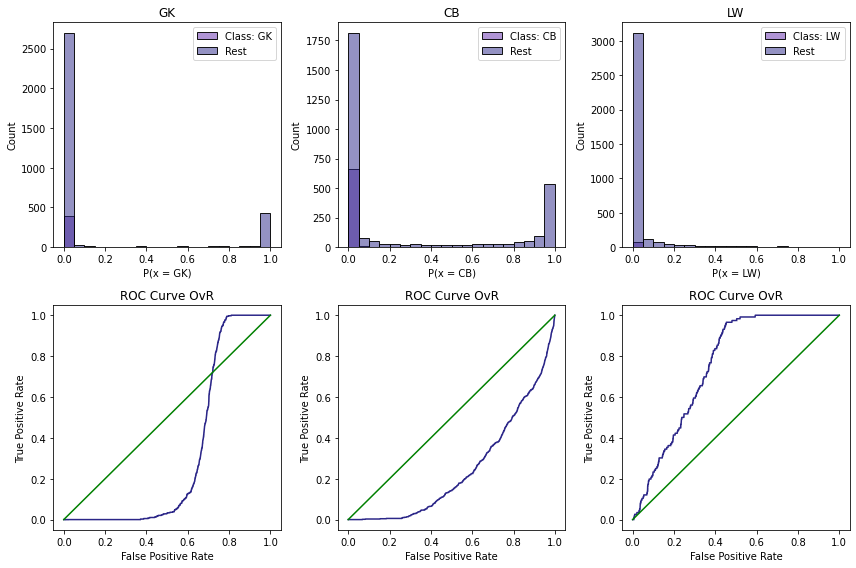

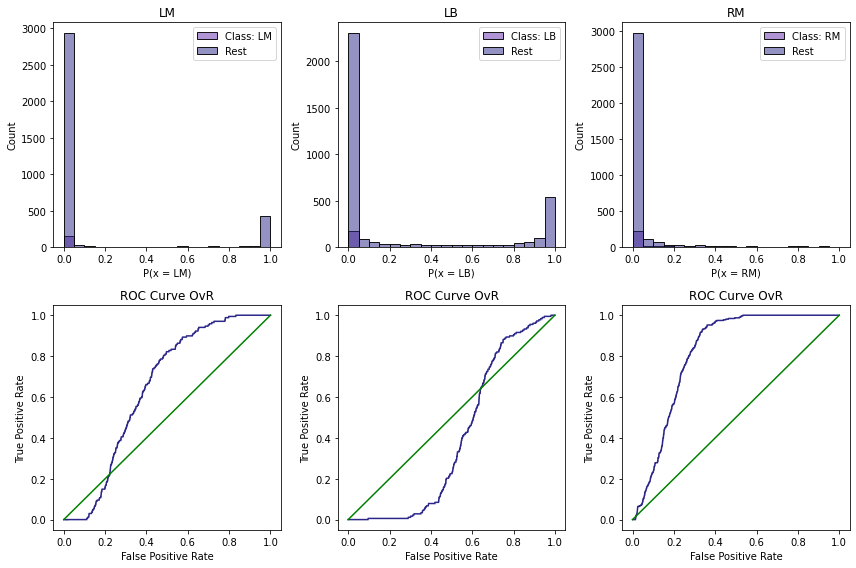

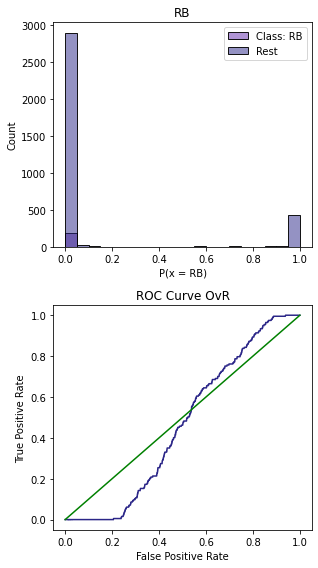

In [72]:
draw_pco(Y_Proba_xgb, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_xgb, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_xgb, ['LM', 'LB','RM'])
draw_pco(Y_Proba_xgb, ['RB'])

In [73]:
auc_score_xgb = roc_auc_score(Y_Test, Y_Proba_xgb, multi_class = 'ovr', average = 'macro')
auc_score_xgb

0.9747158291292906

In [74]:
models_auc_scores.append(auc_score_xgb)

<h3>4. Decision Tree:</h3>

In [75]:
from sklearn.tree  import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_features = 39,max_depth = 10)

In [76]:
dt.fit(X_Train, Y_Train)

DecisionTreeClassifier(max_depth=10, max_features=39)

In [77]:
dt.score(X_Train, Y_Train)

0.7459974037213327

In [78]:
dt.score(X_Test, Y_Test)

0.6422764227642277

In [79]:
Y_Pred_dt = dt.predict(X_Test)

In [80]:
models_names.append("Decision Tree")
models_scores.append(dt.score(X_Test, Y_Test))

In [81]:
classification_report_fun("Decision Tree", Y_Test, Y_Pred_dt)

The Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       522
           1       0.79      0.61      0.69       962
           2       0.17      0.55      0.26       132
           3       1.00      1.00      1.00       391
           4       0.88      0.84      0.86       711
           5       0.16      0.39      0.22       116
           6       0.26      0.47      0.34       168
           7       0.51      0.57      0.54       178
           8       0.54      0.24      0.33       313
           9       0.53      0.28      0.37       197

    accuracy                           0.64      3690
   macro avg       0.57      0.57      0.54      3690
weighted avg       0.73      0.64      0.67      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [82]:
Y_Proba_dt = dt.predict_proba(X_Test)

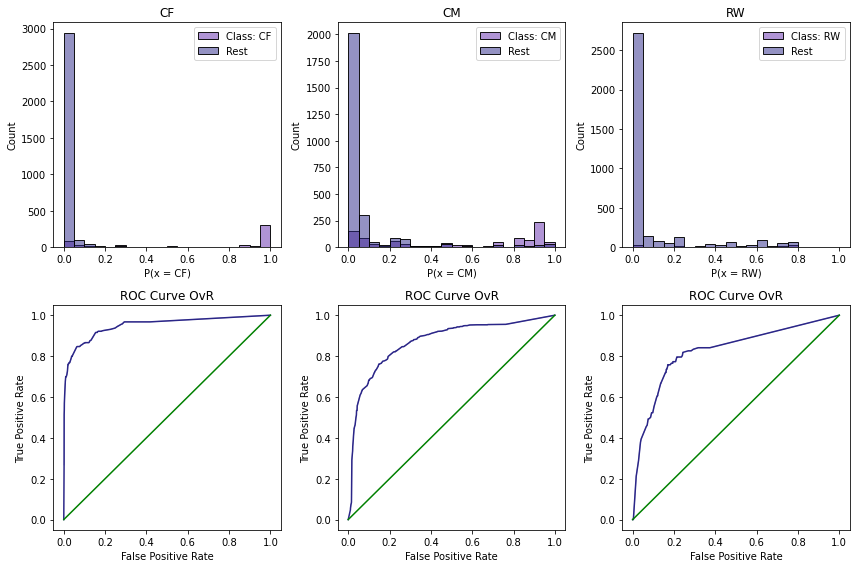

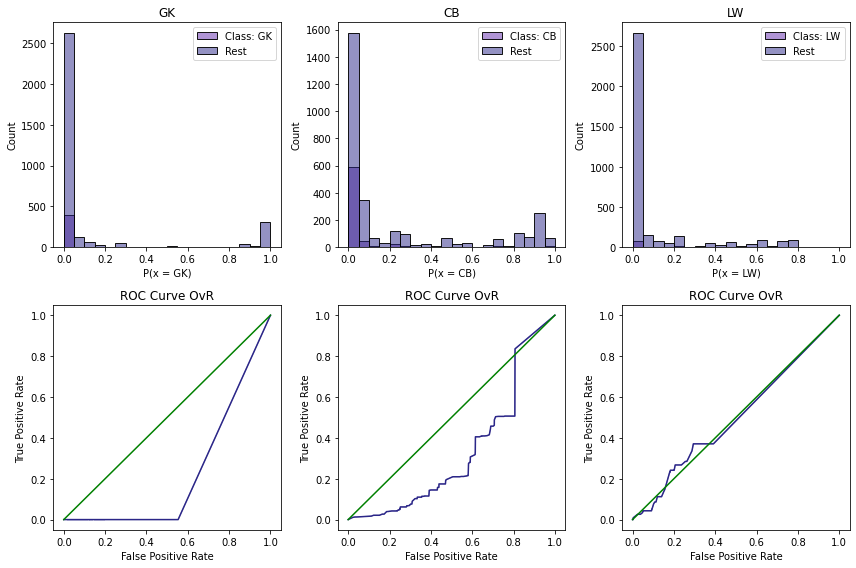

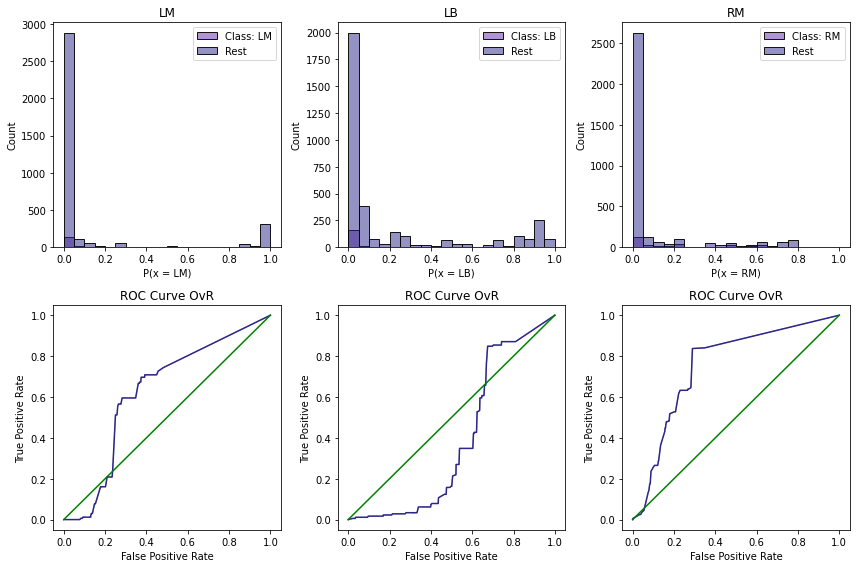

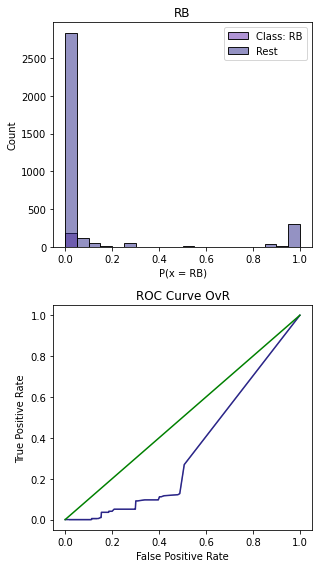

In [83]:
draw_pco(Y_Proba_dt, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_dt, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_dt, ['LM', 'LB','RM'])
draw_pco(Y_Proba_dt, ['RB'])

In [84]:
auc_score_dt = roc_auc_score(Y_Test, Y_Proba_dt, multi_class = 'ovr', average = 'macro')
auc_score_dt

0.8952961947381356

In [85]:
models_auc_scores.append(auc_score_dt)

<h3>5. Adaboost:</h3>

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

In [87]:
ada.fit(X_Train, Y_Train)

AdaBoostClassifier()

In [88]:
ada.score(X_Train, Y_Train)

0.5054089138900909

In [89]:
ada.score(X_Test, Y_Test)

0.6102981029810298

In [90]:
Y_Pred_ada = dt.predict(X_Test)

In [91]:
models_names.append("Adaboost")
models_scores.append(ada.score(X_Test, Y_Test))

In [92]:
classification_report_fun("Adaboost", Y_Test, Y_Pred_ada)

The Classification Report for Adaboost Classifier:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       522
           1       0.79      0.61      0.69       962
           2       0.17      0.55      0.26       132
           3       1.00      1.00      1.00       391
           4       0.88      0.84      0.86       711
           5       0.16      0.39      0.22       116
           6       0.26      0.47      0.34       168
           7       0.51      0.57      0.54       178
           8       0.54      0.24      0.33       313
           9       0.53      0.28      0.37       197

    accuracy                           0.64      3690
   macro avg       0.57      0.57      0.54      3690
weighted avg       0.73      0.64      0.67      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [93]:
Y_Proba_ada = ada.predict_proba(X_Test)

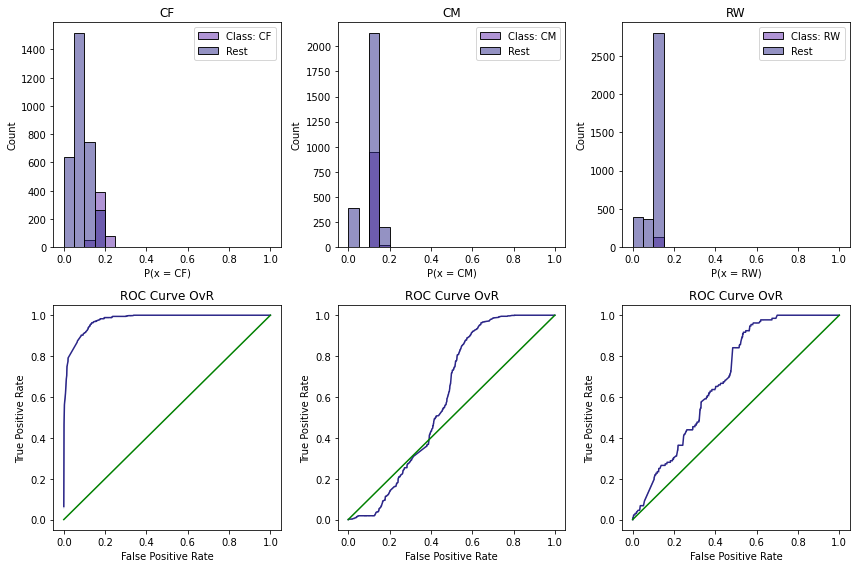

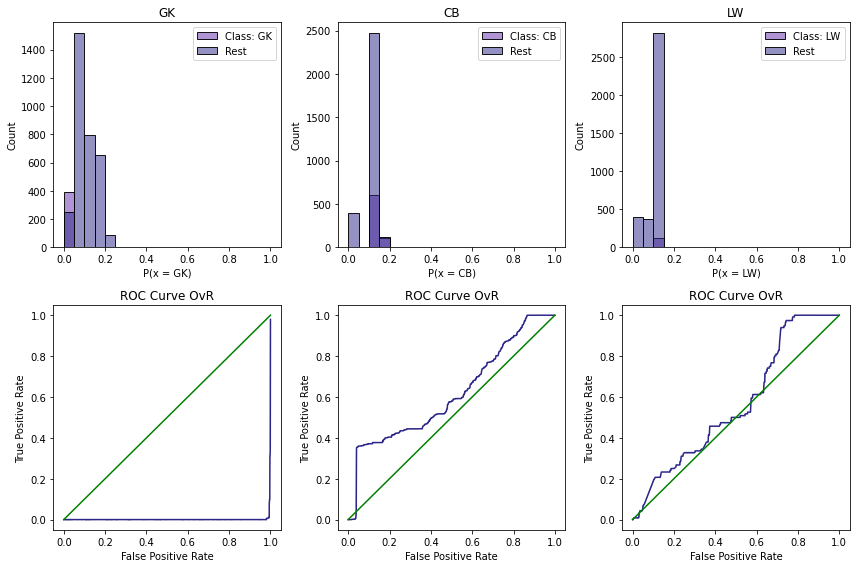

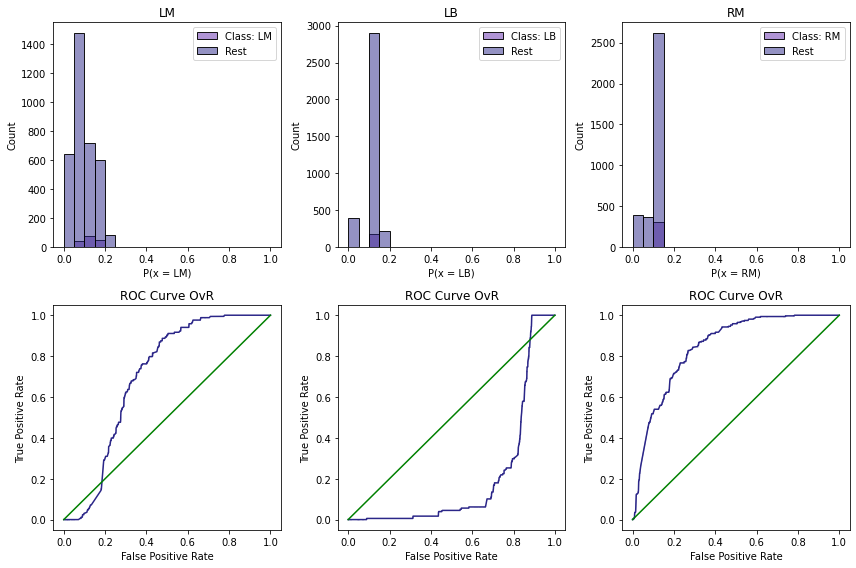

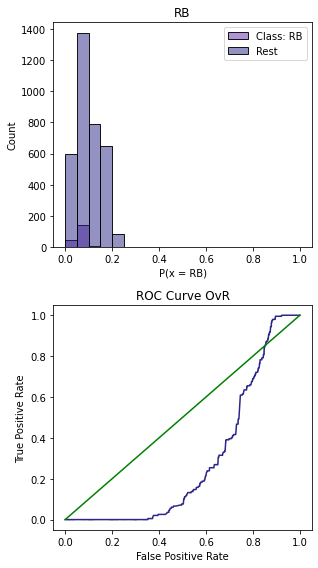

In [94]:
draw_pco(Y_Proba_ada, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_ada, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_ada, ['LM', 'LB','RM'])
draw_pco(Y_Proba_ada, ['RB'])

In [95]:
auc_score_ada = roc_auc_score(Y_Test, Y_Proba_ada, multi_class = 'ovr', average = 'macro')

In [96]:
models_auc_scores.append(auc_score_ada)

<h3>6. light GBM:</h3>

In [97]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(max_depth = 15)

In [98]:
lgbm.fit(X_Train, Y_Train)

LGBMClassifier(max_depth=15)

In [99]:
lgbm.score(X_Train, Y_Train)

0.9998918217221981

In [100]:
lgbm.score(X_Test, Y_Test)

0.8235772357723578

In [101]:
Y_Pred_lgbm = lgbm.predict(X_Test)

In [102]:
models_names.append("light GBM")
models_scores.append(lgbm.score(X_Test, Y_Test))

In [103]:
classification_report_fun("light GBM", Y_Test, Y_Pred_lgbm)

The Classification Report for light GBM Classifier:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       522
           1       0.89      0.85      0.87       962
           2       0.34      0.42      0.38       132
           3       1.00      1.00      1.00       391
           4       0.93      0.95      0.94       711
           5       0.40      0.34      0.36       116
           6       0.54      0.56      0.55       168
           7       0.72      0.78      0.75       178
           8       0.68      0.66      0.67       313
           9       0.69      0.69      0.69       197

    accuracy                           0.82      3690
   macro avg       0.71      0.72      0.71      3690
weighted avg       0.83      0.82      0.82      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [104]:
Y_Proba_lgbm = lgbm.predict_proba(X_Test)

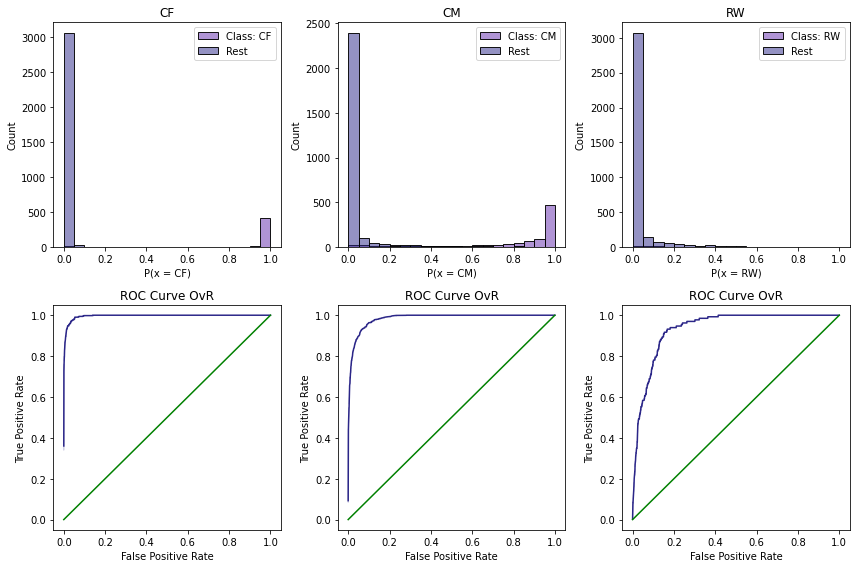

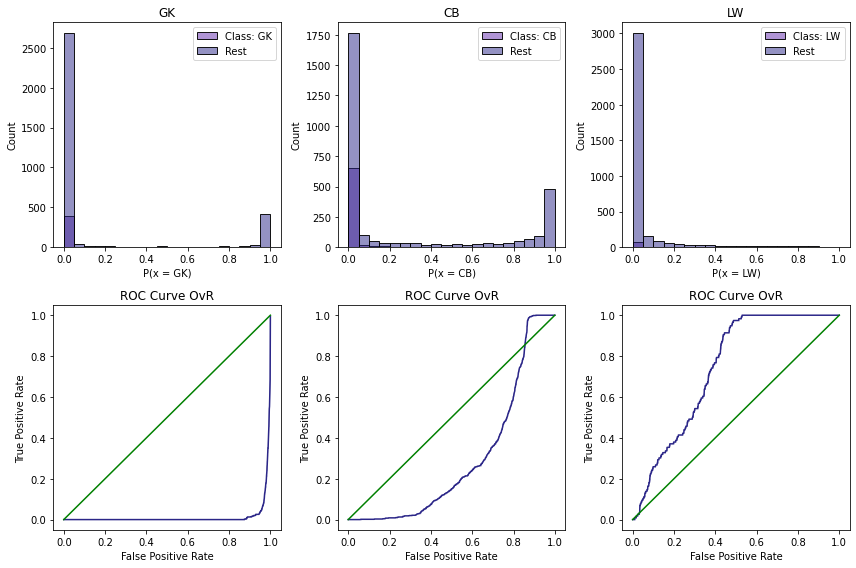

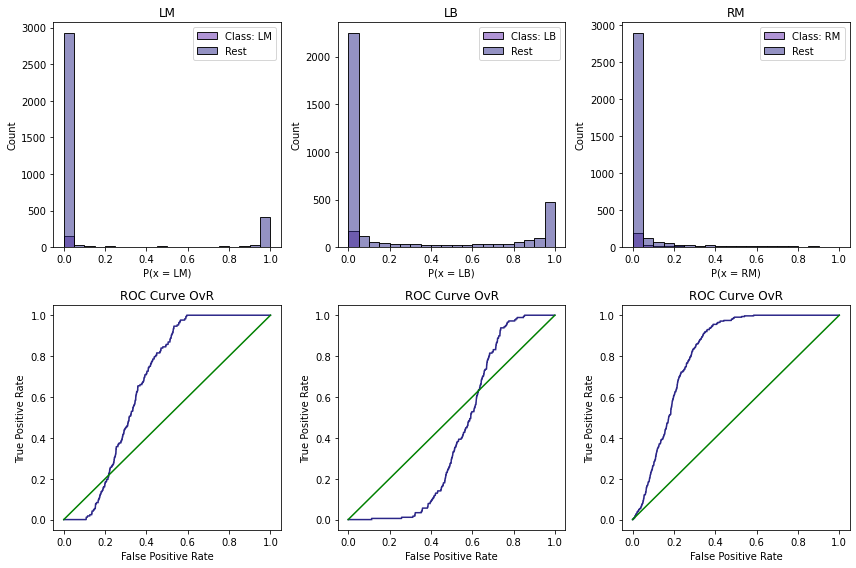

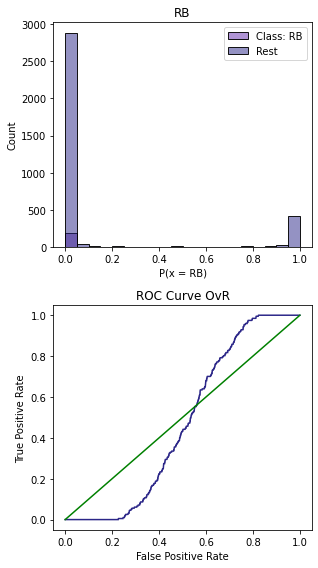

In [105]:
draw_pco(Y_Proba_lgbm, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_lgbm, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_lgbm, ['LM', 'LB','RM'])
draw_pco(Y_Proba_lgbm, ['RB'])

In [106]:
auc_score_lgbm = roc_auc_score(Y_Test, Y_Proba_lgbm, multi_class = 'ovr', average = 'macro')
auc_score_lgbm

0.9739996814071574

In [107]:
models_auc_scores.append(auc_score_lgbm)

<h3>7. CatBoost:</h3>

In [108]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(max_depth = 10, iterations=10, learning_rate=0.3)

In [109]:
cb.fit(X_Train, Y_Train)

0:	learn: 1.5376188	total: 637ms	remaining: 5.74s
1:	learn: 1.2756082	total: 1.16s	remaining: 4.63s
2:	learn: 1.1092352	total: 1.69s	remaining: 3.93s
3:	learn: 1.0010144	total: 2.2s	remaining: 3.3s
4:	learn: 0.9149035	total: 2.74s	remaining: 2.74s
5:	learn: 0.8400658	total: 3.26s	remaining: 2.17s
6:	learn: 0.7794678	total: 3.79s	remaining: 1.62s
7:	learn: 0.7301930	total: 4.31s	remaining: 1.08s
8:	learn: 0.6827092	total: 4.84s	remaining: 537ms
9:	learn: 0.6488312	total: 5.36s	remaining: 0us


In [110]:
cb.score(X_Train, Y_Train)

0.8247872493869898

In [111]:
cb.score(X_Test, Y_Test)

0.71869918699187

In [112]:
Y_Pred_cb = cb.predict(X_Test)

In [113]:
models_names.append("CatBoost")
models_scores.append(cb.score(X_Test, Y_Test))

In [114]:
classification_report_fun("CatBoost", Y_Test, Y_Pred_cb)

The Classification Report for CatBoost Classifier:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       522
           1       0.85      0.72      0.78       962
           2       0.20      0.68      0.31       132
           3       1.00      1.00      1.00       391
           4       0.90      0.88      0.89       711
           5       0.25      0.35      0.29       116
           6       0.36      0.58      0.45       168
           7       0.55      0.71      0.62       178
           8       0.76      0.34      0.47       313
           9       0.72      0.22      0.34       197

    accuracy                           0.72      3690
   macro avg       0.65      0.63      0.60      3690
weighted avg       0.79      0.72      0.73      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [115]:
Y_Proba_cb = cb.predict_proba(X_Test)

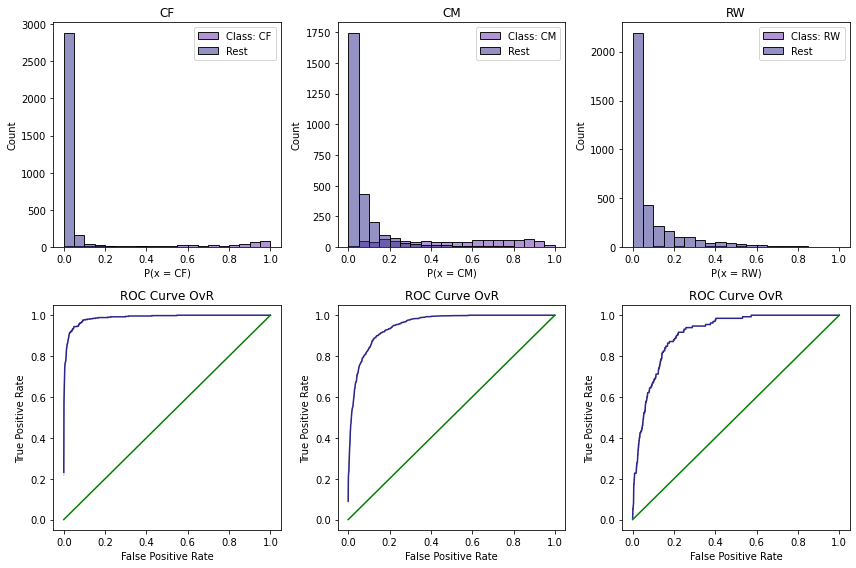

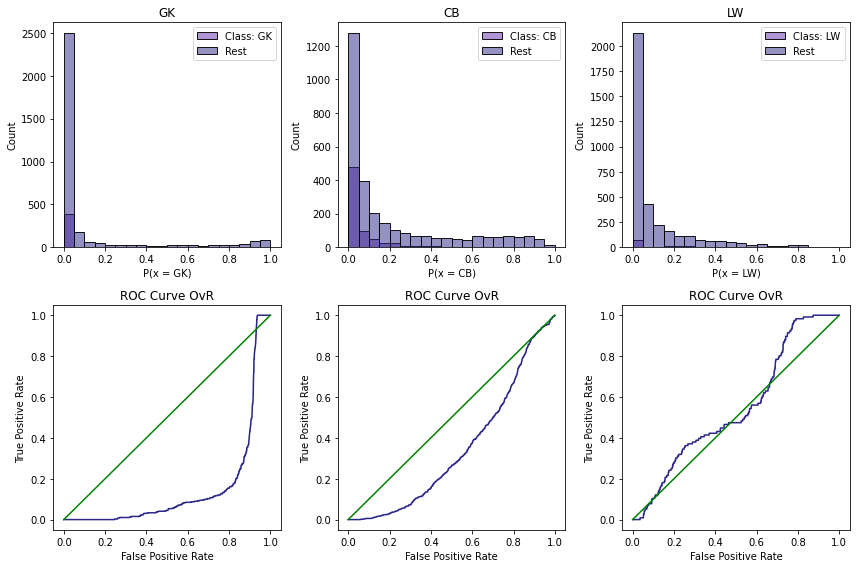

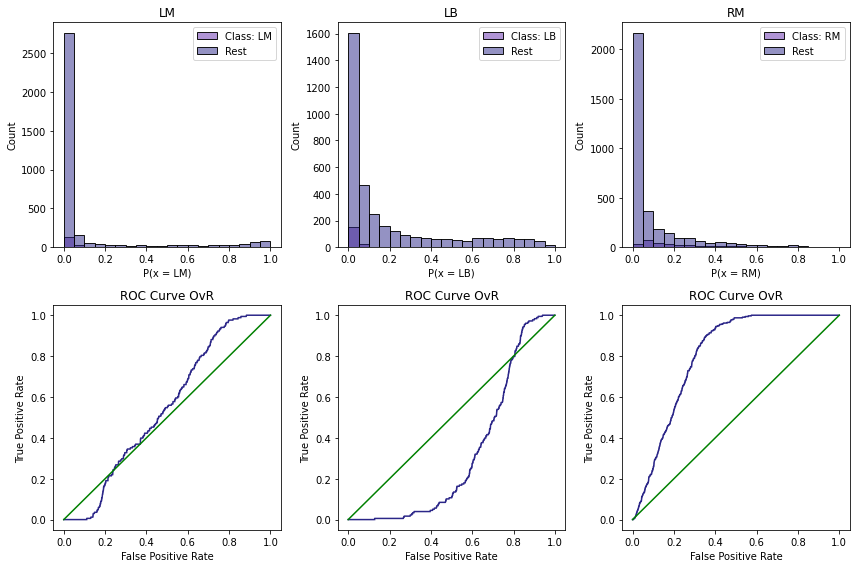

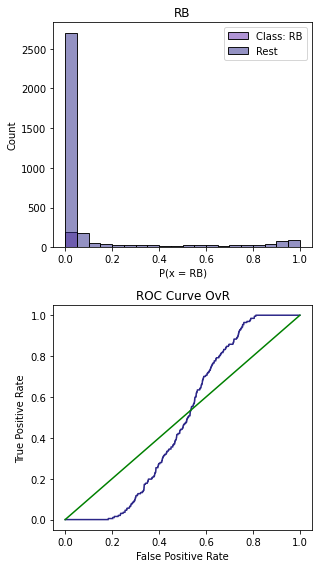

In [116]:
draw_pco(Y_Proba_cb, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_cb, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_cb, ['LM', 'LB','RM'])
draw_pco(Y_Proba_cb, ['RB'])

In [117]:
auc_score_cb = roc_auc_score(Y_Test, Y_Proba_cb, multi_class = 'ovr', average = 'macro')
auc_score_cb

0.9565257789222021

In [118]:
models_auc_scores.append(auc_score_cb)

<h3>8. KNN:</h3>

In [119]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 8)

In [120]:
knn.fit(X_Train, Y_Train)

KNeighborsClassifier(n_neighbors=8)

In [121]:
knn.score(X_Train, Y_Train)

0.8588634068945622

In [122]:
knn.score(X_Test, Y_Test)

0.6311653116531165

In [123]:
Y_Pred_knn = cb.predict(X_Test)

In [124]:
models_names.append("KNN")
models_scores.append(knn.score(X_Test, Y_Test))

In [125]:
classification_report_fun("KNN", Y_Test, Y_Pred_knn)

The Classification Report for KNN Classifier:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       522
           1       0.85      0.72      0.78       962
           2       0.20      0.68      0.31       132
           3       1.00      1.00      1.00       391
           4       0.90      0.88      0.89       711
           5       0.25      0.35      0.29       116
           6       0.36      0.58      0.45       168
           7       0.55      0.71      0.62       178
           8       0.76      0.34      0.47       313
           9       0.72      0.22      0.34       197

    accuracy                           0.72      3690
   macro avg       0.65      0.63      0.60      3690
weighted avg       0.79      0.72      0.73      3690



<h3>Use the ROC Curve and ROC AUC to Evaluate the model:</h3>

In [126]:
Y_Proba_knn = knn.predict_proba(X_Test)

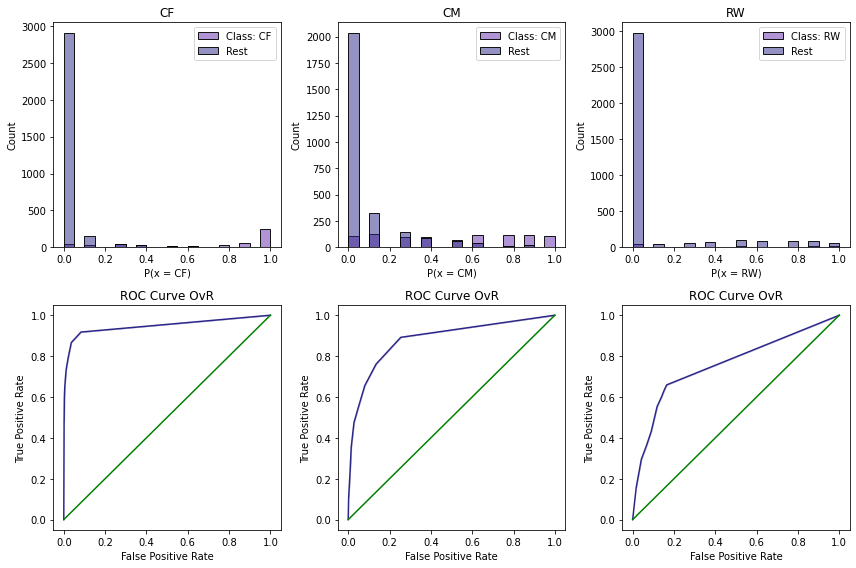

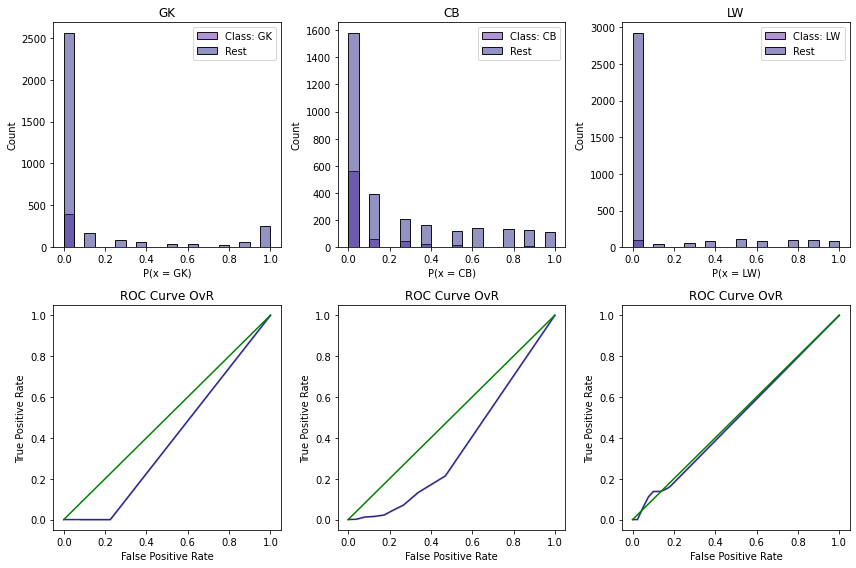

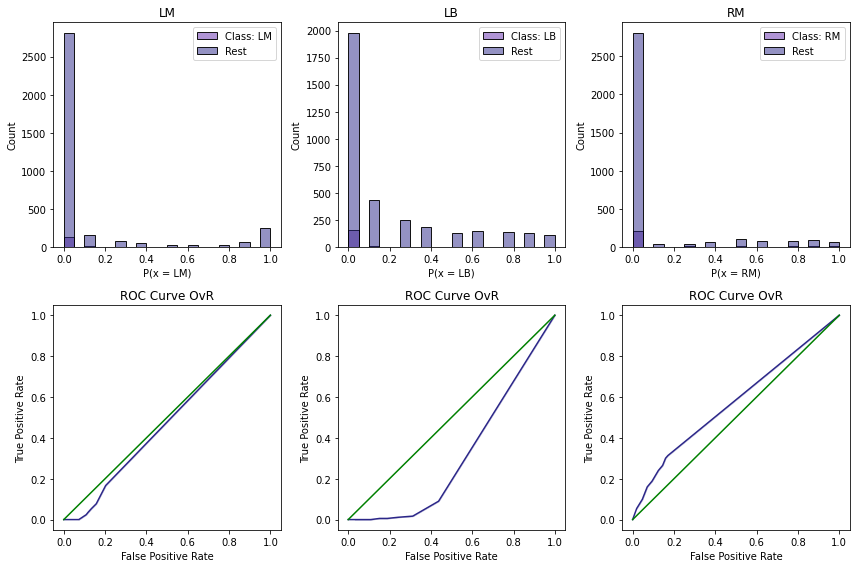

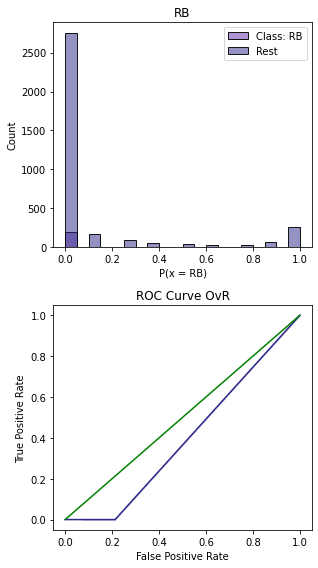

In [127]:
draw_pco(Y_Proba_knn, ['CF', 'CM', 'RW'])
draw_pco(Y_Proba_knn, ['GK', 'CB', 'LW'])
draw_pco(Y_Proba_knn, ['LM', 'LB','RM'])
draw_pco(Y_Proba_knn, ['RB'])

In [128]:
auc_score_knn = roc_auc_score(Y_Test, Y_Proba_knn, multi_class = 'ovr', average = 'macro')
auc_score_knn

0.8541471014345501

In [129]:
models_auc_scores.append(auc_score_knn)

<h3>Compare the Test Accuracy of the 8 Classification Algorithms:</h3>

<h3>Based on the Accuracy: </h3>

In [130]:
comp = pd.DataFrame()
comp['name'] = models_names
comp['score'] = models_scores
comp

,name,score
0,Logistic Regression,0.753659
1,Random Forest,0.805962
2,XGB,0.824932
3,Decision Tree,0.642276
4,Adaboost,0.610298
5,light GBM,0.823577
6,CatBoost,0.718699
7,KNN,0.631165


In [131]:
cm = sns.light_palette("green", as_cmap=True)
s = comp.style.background_gradient(cmap=cm)
s

,name,score
0,Logistic Regression,0.753659
1,Random Forest,0.805962
2,XGB,0.824932
3,Decision Tree,0.642276
4,Adaboost,0.610298
5,light GBM,0.823577
6,CatBoost,0.718699
7,KNN,0.631165


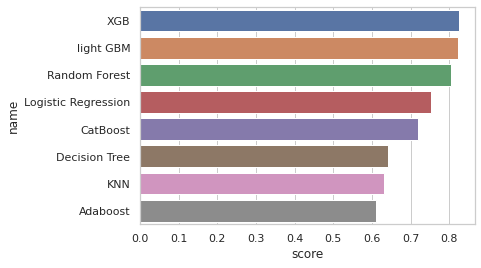

In [132]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=comp.sort_values(by="score", ascending=False))

<h3>Based on the ROC AUC Score:</h3>

In [133]:
comp_auc = pd.DataFrame()
comp_auc['name'] = models_names
comp_auc['score'] = models_auc_scores
comp_auc

,name,score
0,Logistic Regression,0.964473
1,Random Forest,0.964400
2,XGB,0.974716
3,Decision Tree,0.895296
4,Adaboost,0.842583
5,light GBM,0.974000
6,CatBoost,0.956526
7,KNN,0.854147


In [134]:
cm = sns.light_palette("green", as_cmap=True)
s = comp_auc.style.background_gradient(cmap=cm)
s

,name,score
0,Logistic Regression,0.964473
1,Random Forest,0.964400
2,XGB,0.974716
3,Decision Tree,0.895296
4,Adaboost,0.842583
5,light GBM,0.974000
6,CatBoost,0.956526
7,KNN,0.854147


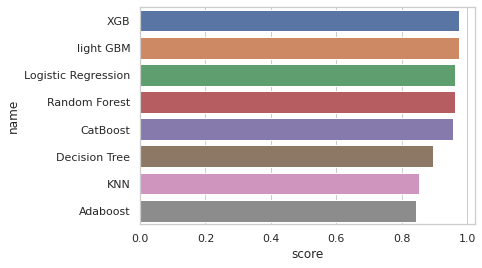

In [135]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=comp_auc.sort_values(by="score", ascending=False))

<h3>So We can deduce that the Best Algorithm for this Data is the XGB </h3>

<h3>Test the Algorithm on the top 20 Players:</h3>

In [136]:
top = pd.DataFrame(top)

for i in range(top.shape[0]):
    pred_pos = xgb.predict(top.iloc[[i]])[0]
    
    pred = list(mapping.keys())[list(mapping.values()).index(pred_pos)]
    true_pos = list(mapping.keys())[list(mapping.values()).index(top_pos.iloc[i])]

    print('Name: {}\nPrediction: {}\n True Best Pos: {}\n'.format(top_names.iloc[i], pred, true_pos))

Name: L. Messi
Prediction: CM
 True Best Pos: CM

Name: R. Lewandowski
Prediction: CF
 True Best Pos: CF

Name: K. De Bruyne
Prediction: CM
 True Best Pos: CM

Name: K. Mbappé
Prediction: LW
 True Best Pos: CF

Name: K. Benzema
Prediction: CF
 True Best Pos: CF

Name: M. Salah
Prediction: RW
 True Best Pos: RW

Name: T. Courtois
Prediction: GK
 True Best Pos: GK

Name: M. Neuer
Prediction: GK
 True Best Pos: GK

Name: Cristiano Ronaldo
Prediction: CF
 True Best Pos: CF

Name: V. van Dijk
Prediction: CB
 True Best Pos: CB

Name: S. Mané
Prediction: RM
 True Best Pos: LM

Name: N. Kanté
Prediction: CM
 True Best Pos: CM

Name: J. Kimmich
Prediction: CM
 True Best Pos: CM

Name: Ederson
Prediction: GK
 True Best Pos: GK

Name: Alisson
Prediction: GK
 True Best Pos: GK

Name: J. Oblak
Prediction: GK
 True Best Pos: GK

Name: Casemiro
Prediction: CB
 True Best Pos: CM

Name: H. Son
Prediction: CF
 True Best Pos: LW

Name: H. Kane
Prediction: CF
 True Best Pos: CF

Name: Neymar Jr
Prediction